In [26]:
import numpy as np
import simulation_manager, results_annalysis
import instance_genrerantion
import matplotlib.pyplot as plt
import time
import pandas as pd

## Création de l'instance

#### Génération d'une instance par réduction

In [27]:
from problem_reductions.npp_to_ising import *
# NPP instance
weights = [1, 2, 3, 4]

# Ising instance
J, H = npp_to_ising(weights=weights)

#### Ou génération d'un instance aléatoire

In [28]:
instance_size = 2000
np.random.seed(4)
J, H = instance_genrerantion.generate_instance(size=instance_size)
J = np.random.normal(loc=0, scale=4, size=(instance_size, instance_size))
np.fill_diagonal(J, 0)
J = (J + J.T) / 2

In [29]:
def read_graph(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        N, E = map(int, lines[0].split())
        graph = np.zeros((N, N))
        for line in lines[1:]:
            i, j, w = map(int, line.split())
            graph[i-1, j-1] = w
            graph[j-1, i-1] = w  # since the graph is undirected
            
    return np.array(graph)

graph = read_graph('MAX-CUT dataset/G2')
size = 800
graph = graph[:size, :size]
J = graph/2
np.fill_diagonal(J, 0)
H = np.zeros(size)

In [30]:
graph

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [31]:
eigs = np.linalg.eigvals(J)
print("J max-min eigenvalues: ", (eigs.min(), eigs.max()))

J max-min eigenvalues:  (-6.697893658229725, 24.424309208521255)


In [32]:
# ksi = 0.5/np.sqrt( np.sum(np.square(J)) / (instance_size-1) )
ksi = 1/(eigs.max())
ksi

0.0409428160879619

In [33]:
p_first = 1-ksi*np.real(eigs.max())
p_last = 1-ksi*np.real(eigs.min())
p_first, p_last

(0.0, 1.274230628225626)

In [34]:
num_iterations = 1000
lag = 0

def pumpuing_rate(self, t):
    if t<lag:
        return 0
    else:
        return 1 * p_last * (t-lag)/(num_iterations-lag)

In [35]:
t_first, t_last = lag + (num_iterations-lag)*p_first, lag + (num_iterations-lag)*p_last

In [36]:
pumpuing_rate(_, t_first)

0.0

## Simulation avec des paramètres choisis

In [37]:
manager = simulation_manager.SimulationManager(step_size=0.5, num_iterations=num_iterations, num_simulations=2, J=J, H=H, pumping_rate=pumpuing_rate, stopping_criterion=0.1, save_states_history=True, save_energies_history=True, n_threads=2, savetofile=False)

In [38]:
states, energies, last_states, last_TAC_states, last_sign_States, last_energies, last_TAC_energies, last_sign_energies, final_times, sign_times, TAC_times = manager.run_simulation()

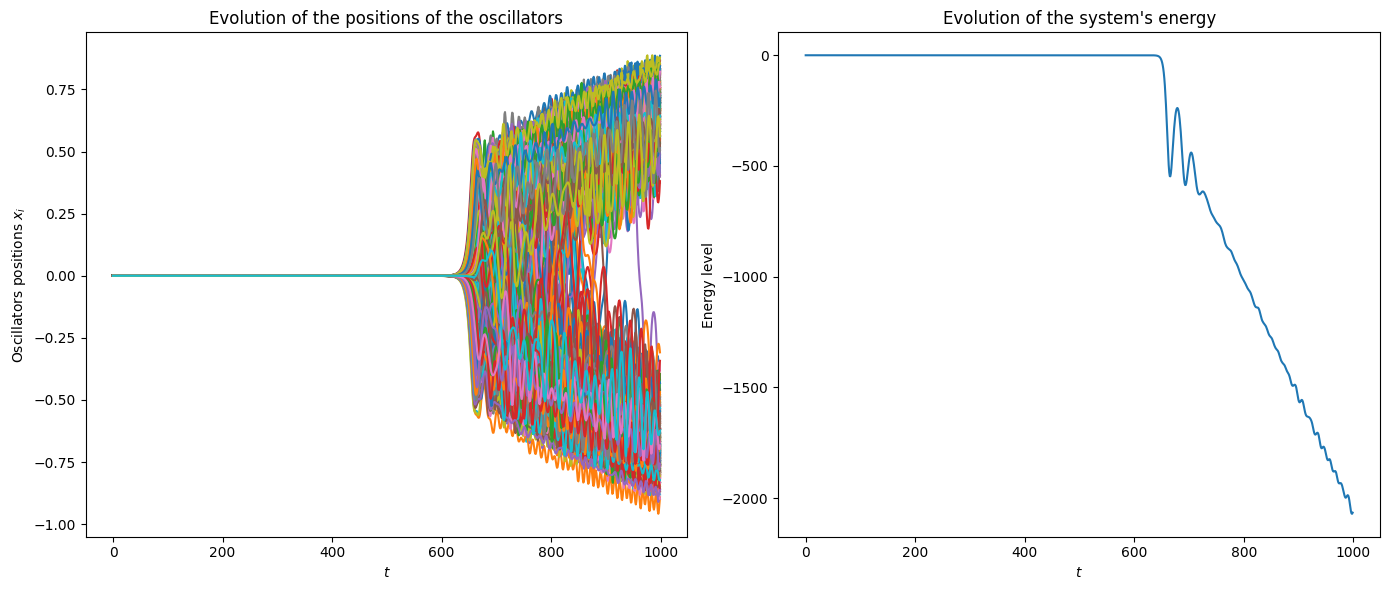

In [39]:
results_annalysis.complete_plot(states, energies, 0)

In [40]:
solution = np.sign(last_states[0, :, 0])

In [41]:
def calculate_cut_value(adj_matrix, solution):
    cut_value = 0
    for i in range(len(solution)):
        for j in range(len(solution)):
            if solution[i] != solution[j]:
                cut_value += adj_matrix[i][j]
    return cut_value/2

In [42]:
calculate_cut_value(graph, solution)

11556.0

In [43]:
cut_values = []
for i in [1,2,3,24,59]:
    graph = read_graph(f'MAX-CUT dataset/G{i}')
    size = graph.shape[0]
    graph = graph[:size, :size]
    J = graph/2
    np.fill_diagonal(J, 0)
    H = np.zeros(size)

    eigs = np.linalg.eigvals(J)

    ksi = 1/(eigs.max()+1)

    p_first = 1-ksi*np.real(eigs.max())
    p_last = 1-ksi*np.real(eigs.min())

    num_iterations = 1000
    lag = 0

    def pumpuing_rate(self, t):
        if t<lag:
            return 0
        else:
            return 1.5 * p_last * (t-lag)/(num_iterations-lag)
        
    manager = simulation_manager.SimulationManager(step_size=0.5, num_iterations=num_iterations, num_simulations=2, J=J, H=H, pumping_rate=pumpuing_rate, stopping_criterion=0.1, save_states_history=True, save_energies_history=True, n_threads=2, savetofile=False)
    states, energies, last_states, last_TAC_states, last_sign_States, last_energies, last_TAC_energies, last_sign_energies, final_times, sign_times, TAC_times = manager.run_simulation()

    solution = np.sign(last_states[0, :, 0])
    cut_value = calculate_cut_value(graph, solution)
    cut_values.append(cut_value)

In [44]:
cut_values

[11530.0, 11505.0, 11532.0, 13254.0, 5627.0]

In [45]:
target_values = [11624, 11620, 11622, 13337, 6067]
target_values

[11624, 11620, 11622, 13337, 6067]

In [46]:
np.array(cut_values)/np.array(target_values)

array([0.99191328, 0.99010327, 0.99225607, 0.99377671, 0.92747651])

In [47]:
final_times, sign_times, TAC_times

([23.457242012023926, 14.048116207122803],
 [56.639219999313354, 45.56086039543152],
 [6.741461753845215, 6.666680097579956])

In [48]:
perfs = np.zeros(shape=(2, 2))
perfs[:, 0] = last_sign_energies
perfs[:, 1] = last_sign_energies

In [49]:
perfs

array([[nan, nan],
       [nan, nan]])

In [50]:
# [last_energies[0].mean(), last_TAC_energies[0].mean(), last_sign_energies[0].mean(), end_t-start_t]

In [51]:
manager.save_energies_history = False
manager.save_states_history = False
manager.stopping_criterion = 0.3
manager.num_simulations = 2

performances = [] # will hold lits of last_energies, last_TAC_energies, last_sign_energies

ks = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

for k in ks:
    _, _, last_states, last_TAC_states, last_sign_States, last_energies, last_TAC_energies, last_sign_energies, final_times, sign_times, TAC_times = manager.run_simulation()

    perf = [last_energies[0].mean(), last_TAC_energies[0].mean(), last_sign_energies[0].mean(), final_times[0], TAC_times[0], sign_times[0]]
    performances.append(perf)

TypeError: 'NoneType' object is not subscriptable

In [ ]:
np.array(performances).shape

(9, 6)

In [ ]:
df = pd.DataFrame(performances, columns=['final_sign_energies', 'last_TAC_energies', 'sign_energies', 'final_time', 'TAC_time', 'sign_time'])

In [ ]:
df.head()

,final_sign_energies,last_TAC_energies,sign_energies,final_time,TAC_time,sign_time
0,-379058.287517,-379058.287517,-379615.796247,4.150421,1.482984,0.162025
1,-380509.065265,-380509.065265,-380799.256976,4.430960,1.458688,0.142570
2,-379447.636137,-379447.636137,-380022.073672,4.191874,1.391705,0.142948
3,-377556.381912,-377556.381912,-378153.568903,3.954197,1.376605,0.111323
4,-380806.090351,-380806.090351,-381023.230853,3.801933,1.359168,0.104891


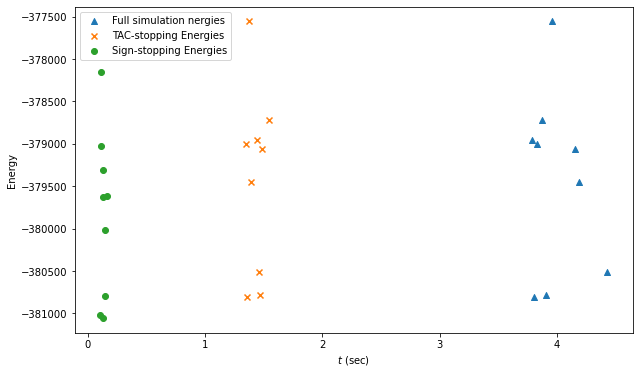

In [ ]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['final_time'], df['final_sign_energies'], marker='^', label='Full simulation nergies') # Circle marker
plt.scatter(df['TAC_time'], df['last_TAC_energies'], marker='x', label='TAC-stopping Energies') # Cross marker
plt.scatter(df['sign_time'], df['sign_energies'], marker='o', label='Sign-stopping Energies') # Cross marker  


# Adding labels and title
plt.xlabel("$t$ (sec)")
plt.ylabel('Energy')
# plt.title('Energy vs. Time Scatter Plot')
plt.legend()
plt.savefig('figures/energy_vs_time_normal_2000.png', dpi=300)

In [ ]:
def compute_forces(positions): 
    #-------- Gradient of the potential energy --------
    forces = -np.dot(J, positions.T).T
    
    return forces
    #-------- For CIM amplitude dynamics --------
    # forces += (-1 + self.pumping_rate(t) - np.square(positions)) * positions

In [ ]:
def TAC(current_state):
        current_state = np.copy(current_state)

        all_positions = current_state[:, :, 0]

        k = 0.5
        
        all_spins = np.zeros_like(all_positions)

        for sim_index in range(2):
                positions = all_positions[sim_index]
                epsilon = k*np.linalg.norm(positions)/np.sqrt(800)
         
                # STEP 1: Trap the traped nodes and put the swing nodes to zero
                spins = np.where(np.abs(positions) < epsilon, 0, np.sign(positions))
                # print(spins)
                # STEP 2:
                zero_indexes = np.where(spins==0)[0]

                
                while zero_indexes.shape[0] != 0:
                        index = np.random.randint(0, zero_indexes+1)
                        spins[index] = np.sign(compute_forces(spins)[index])
                        
                        
                        prev_count = zero_indexes.shape[0]
                        zero_indexes = np.where(spins!=0)[0]
                        if zero_indexes.shape[0] == prev_count:
                                print("TAC failed to converge")
                                break
                
                all_spins[sim_index] = spins
        
        return all_spins

In [ ]:
def TAC(current_state):
        current_state = np.copy(current_state)

        positions = current_state[:, :, 0]

        k = 0.5
        
        spins = np.zeros_like(positions)

        epsilons = k*np.linalg.norm(positions)/np.sqrt(800)        

        # STEP 1: Trap the traped nodes and put the swing nodes to zer
        spins = np.where(np.abs(positions) < epsilons, 0, np.sign(positions))

        # STEP 2: Randomly select the the oder in which we are going to set the spins associated to the swing nodes
        zero_indexes = np.where(spins==0)

        # STEP 3:
        for sim_index in range(2):
                sim_spins = spins[sim_index]
                zero_indexes = np.where(sim_spins==0)[0]
                np.random.shuffle(zero_indexes)

                for index in zero_indexes:
                        sim_spins[index] = np.sign(compute_forces(sim_spins)[index])
                
                prev_count = zero_indexes.shape[0]
                zero_indexes = np.where(sim_spins==0)[0]
                if zero_indexes.shape[0] == prev_count:
                        print("TAC failed to converge")
                        break
                
                spins[sim_index] = sim_spins
        
        return spins

In [ ]:
currrent_state = states[:, :, 100, :]
TAC(currrent_state).shape

(2, 800)

In [ ]:
def compute_energies(positions):
        signed_positions = np.where(positions > 0, 1, -1)
        current_energies = np.sum(signed_positions @ J * signed_positions, axis=1) + H @ signed_positions.T

        return current_energies

In [ ]:
TACed_energies = np.zeros((num_iterations, 2))
singed_energies = np.zeros((num_iterations, 2))

for t in range(num_iterations):
    current_state = states[:, :, t, :] # (num_simulations, instance_size, 2)
    TACed_positions = TAC(current_state) # (num_simulations, instance_size)
    TACed_energies[t] = compute_energies(TACed_positions)

    singed_energies[t] = compute_energies(np.sign(current_state[:, :, 0]))

KeyboardInterrupt: 

Text(0.5, 0, '$t$')

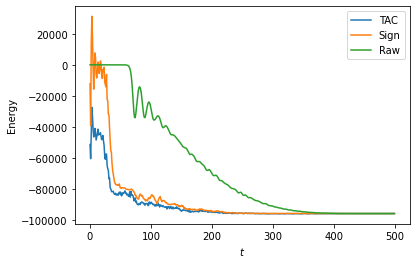

In [ ]:
plt.plot(TACed_energies[:, 0][:]);
plt.plot(singed_energies[:, 0][:]);
plt.plot(energies[0, :][:]);
plt.legend(['TAC', 'Sign', 'Raw'])
# plt.title("Impact of early stoping techniques on the system energies")
plt.ylabel("Energy")
plt.xlabel("$t$")
# plt.savefig('figures/early_stoping_CIM_normal.png', dpi=1200)

In [ ]:
TACed_energies_avg = TACed_energies.mean(axis=1)
signed_energies_avg = singed_energies.mean(axis=1)

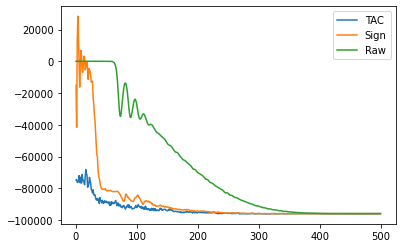

In [ ]:
plt.plot(TACed_energies_avg);
plt.plot(signed_energies_avg);
plt.plot(energies.mean(axis=0));
plt.legend(['TAC', 'Sign', 'Raw'])

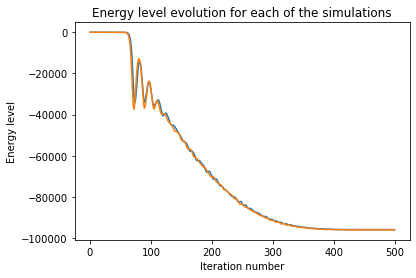

-96050.07355149815

In [ ]:
results_annalysis.plot_energies_evolution(energies)
results_annalysis.extract_full_solution(states, energies)[0]

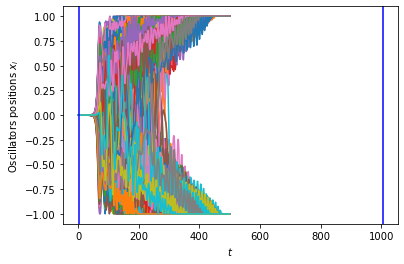

In [ ]:
# positions = states[:, :, :, 0]
# n_cond_init, n_particle,  n_iterration = positions.shape 
# abcisses = np.arange(n_iterration)

# for i in range(n_particle):
#     plt.plot(abcisses, (positions[1, i, :]))
#     plt.xlabel("$t$")
#     plt.ylabel("Oscillators positions $x_i$")
#     # plt.title("Evolution of the positions of the oscillators")

# plt.axvline(x = t_first, color = 'b', label = 'axvline - full height')
# plt.axvline(x = t_last, color = 'b', label = 'axvline - full height')
# plt.savefig('figures/bifurcation_control_CIM_normal.jpg', dpi=1200)
# # plt.plot(abcisses, pressures)

In [ ]:
positions = positions[:, :, 253]

In [ ]:
positions = positions[0]

In [ ]:
indexes = np.where(positions==1)[0]
indexes

array([  8,  10,  16,  22,  24,  26,  27,  29,  39,  54,  60,  83,  91,
       103, 109, 112, 118, 121, 130, 131, 133, 136, 142, 143, 149, 154,
       156, 165, 172, 179, 186, 188, 190, 199, 201, 206, 223, 226, 241,
       247, 249, 258, 263, 264, 266, 267, 269, 281, 284, 297, 300, 314,
       315, 322, 324, 328, 330, 332, 335, 339, 340, 345, 348, 349, 351,
       364, 365, 385, 387, 392, 393, 396, 399, 407, 411, 414, 424, 426,
       430, 438, 441, 447, 457, 465, 474, 481, 482, 485, 505, 507, 511,
       516, 519, 520, 531, 540, 546, 562, 567, 571, 572, 577, 582, 586,
       590, 596, 604, 618, 622, 633, 634, 635, 655, 657, 658, 659, 672,
       675, 697, 702, 703, 704, 706, 712, 717, 719, 720, 723, 727, 732,
       739, 742, 752, 755, 757, 760, 772, 783, 784, 789, 791])

In [ ]:
np.random.shuffle(indexes)
indexes

array([340,  91, 103, 267, 339, 727, 297, 789, 720, 732, 364, 582, 505,
       562, 263, 188, 655, 133, 635, 755, 672, 136, 131, 757, 791, 482,
       223, 172, 457, 258, 424, 577, 519, 324, 314,  10, 531, 704, 351,
       414, 441, 596, 657, 784, 149, 659, 772, 426, 396, 109, 247, 516,
       206, 447, 387, 712, 697, 118,   8, 485, 702,  83, 385, 703, 199,
       143,  27,  24, 154,  54,  60, 474, 717, 226, 658, 760, 465,  29,
       186, 706, 121, 201, 249, 742, 335, 315, 739, 349, 590, 633, 567,
       507, 430, 165, 142, 675, 179, 269, 330, 481, 332, 393, 322, 365,
       719, 540, 130, 604, 546, 634, 264, 723, 399, 156, 190, 618, 572,
       407, 345, 328, 348, 411,  16, 586, 511, 281,  39,  22, 622,  26,
       241, 284, 300, 783, 438, 266, 752, 392, 571, 520, 112])